Follow the demo and run the demo notebook on your local machine.

BERT for QnA:

1. Load the SQUAD 2.0 (https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2Links to an external site.) dataset from pytorch dataset library. take minimum 20 QnA pairs.

2. Display a few raw QnA data samples.

3. Preprocess/Clean dataset as per BERT format.

4. Train the BERT QnA model. Evaluate the model.

5. Perform an Inference and show the predicted vs ground truth answers.

In [ ]:
!pip install transformers
!pip install torchtext
!pip install portalocker
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering
import time
import torchtext

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Load the SQUAD 2.0 (https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2Links to an external site.) dataset from pytorch dataset library. take minimum 20 QnA pairs.

In [ ]:
train_iter, dev_iter = torchtext.datasets.SQuAD2()

In [ ]:
train_iter = iter(train_iter)
dev_iter = iter(dev_iter)

In [ ]:
datapoint = next(dev_iter)

In [ ]:
datapoint

('The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'In what country is Normandy located?',
 ['France', 'France', 'France', 'France'],
 [159, 159, 159, 159])

'France'

In [ ]:
datapoint[1]

'Who was the duke in the battle of Hastings?'

In [ ]:
datapoint[2]

['William the Conqueror', 'William the Conqueror', 'William the Conqueror']

In [ ]:
datapoint[3]

[1022, 1022, 1022]

In [ ]:
contexts = []
questions = []
answers = []
answer_starts = []
answer_ends = []

i = 0
while i < 200:
  datapoint = next(dev_iter)
  if datapoint[2][0] != '':
    i = i + 1
    contexts.append(datapoint[0])
    questions.append(datapoint[1])
    answers.append(datapoint[2][0])
    answer_starts.append(datapoint[3][0])
    answer_ends.append(datapoint[3][0] + len(datapoint[2][0]))

In [ ]:
import random
train_indices = random.sample(range(1, 200), 160)

In [ ]:
train_answers = [answers[i] for i in train_indices]
test_answers = [answers[i] for i in range(len(answers)) if i not in train_indices]

In [ ]:
test_answers

['United States Census Bureau',
 'Orange',
 'Mediterranean',
 'Pacific Ocean',
 '6.7',
 '$20 billion',
 '6.7',
 'occurrence',
 'economically',
 'global',
 'economic',
 '2010',
 '10.0%',
 'tech-oriented',
 'Greater Sacramento',
 'Metropolitan Statistical Areas',
 'Southern Border Region',
 '17,786,419',
 'Los Angeles',
 '100,000']

## Display a few raw QnA data samples.

In [ ]:
for i in range(5):
    print(f"Context: {contexts[i]}")
    print(f"Question: {questions[i]}")
    print(f"Real Answer: {answers[i]}")
    print(f"########################")

Context: Los Angeles (at 3.7 million people) and San Diego (at 1.3 million people), both in southern California, are the two largest cities in all of California (and two of the eight largest cities in the United States). In southern California there are also twelve cities with more than 200,000 residents and 34 cities over 100,000 in population. Many of southern California's most developed cities lie along or in close proximity to the coast, with the exception of San Bernardino and Riverside.
Question: Other than San Bernardino, which other developed southern Californian city is not in close proximity to the coast?
Real Answer: Riverside
########################
Context: Southern California's economy is diverse and one of the largest in the United States. It is dominated and heavily dependent upon abundance of petroleum, as opposed to other regions where automobiles not nearly as dominant, the vast majority of transport runs on this fuel. Southern California is famous for tourism and H

In [ ]:
questions

['Who considers Los Angeles County to be a separate metropolitan area?',
 'Other than L.A. which other county do many people commute to?',
 'Other than the 1980s, in which decade did most of San Bernardino and Riverside Counties develop?',
 'What kind of climate does southern California maintain?',
 'Other than many sunny days, what characteristic is typical for the climate in souther California?',
 'What is the low end of the temperature range in summer?',
 'How frequent is snow in the Southwest of the state?',
 'What is the high end of the temperature range in winter?',
 "What term best describes southern California's collection of landscapes?",
 'The region spans starting at islands found in which body of water?',
 'What type of landscapes other than geologic and natural ecosystem landscapes can be found in southern California?',
 'The region spans which mountains other than the Transverse ranges?',
 'The mountain ranges tail off into what kind of geographical formation?',
 'How man

In [ ]:
answers

['United States Census Bureau',
 'Orange',
 '1990s',
 'Mediterranean',
 'infrequent rain',
 "60's",
 'very rare',
 '70',
 'varied',
 'Pacific Ocean',
 'topographic',
 'Peninsular',
 'valleys',
 '10,000',
 'small',
 '6.7',
 'property damage',
 '$20 billion',
 'San Andreas',
 '6.7',
 'Puente Hills',
 'USGS',
 'occurrence',
 'economically',
 'global',
 'economic',
 '2010',
 'high growth rates',
 '10.0%',
 'tech-oriented',
 'Greater Sacramento',
 'Metropolitan Statistical Areas',
 'two',
 'five million',
 'Southern Border Region',
 '17,786,419',
 'Los Angeles',
 '1.3 million',
 'twelve',
 '100,000']

In [ ]:
answer_starts

[318,
 521,
 688,
 31,
 59,
 243,
 353,
 269,
 48,
 222,
 80,
 313,
 383,
 50,
 96,
 246,
 402,
 471,
 73,
 44,
 181,
 234,
 309,
 60,
 207,
 254,
 10,
 114,
 196,
 311,
 365,
 69,
 197,
 241,
 672,
 311,
 0,
 54,
 250,
 316]

In [ ]:
answer_ends

[345,
 527,
 693,
 44,
 74,
 247,
 362,
 271,
 54,
 235,
 91,
 323,
 390,
 56,
 101,
 249,
 417,
 482,
 84,
 47,
 193,
 238,
 319,
 72,
 213,
 262,
 14,
 131,
 201,
 324,
 383,
 99,
 200,
 253,
 694,
 321,
 11,
 65,
 256,
 323]

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer("Where do you live", "I live in San Jose.")

{'input_ids': [101, 2073, 2079, 2017, 2444, 102, 1045, 2444, 1999, 2624, 4560, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
questions[0]

'Who considers Los Angeles County to be a separate metropolitan area?'

In [ ]:
contexts[0]

'Traveling south on Interstate 5, the main gap to continued urbanization is Camp Pendleton. The cities and communities along Interstate 15 and Interstate 215 are so inter-related that Temecula and Murrieta have as much connection with the San Diego metropolitan area as they do with the Inland Empire. To the east, the United States Census Bureau considers the San Bernardino and Riverside County areas, Riverside-San Bernardino area as a separate metropolitan area from Los Angeles County. While many commute to L.A. and Orange Counties, there are some differences in development, as most of San Bernardino and Riverside Counties (the non-desert portions) were developed in the 1980s and 1990s. Newly developed exurbs formed in the Antelope Valley north of Los Angeles, the Victor Valley and the Coachella Valley with the Imperial Valley. Also, population growth was high in the Bakersfield-Kern County, Santa Maria and San Luis Obispo areas.'

In [ ]:
tokenized_example = tokenizer(
    questions[0],
    contexts[0],
    return_offsets_mapping=True
)

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


In [ ]:
tokenized_example['offset_mapping']

[(0, 0),
 (0, 5),
 (6, 10),
 (11, 14),
 (15, 25),
 (25, 26),
 (27, 32),
 (33, 38),
 (39, 48),
 (49, 57),
 (58, 68),
 (68, 69),
 (70, 74),
 (75, 77),
 (78, 81),
 (82, 84),
 (85, 90),
 (91, 100),
 (101, 103),
 (104, 107),
 (108, 113),
 (113, 114),
 (0, 0),
 (0, 3),
 (4, 11),
 (12, 13),
 (13, 15),
 (16, 17),
 (17, 18),
 (18, 19),
 (20, 27),
 (28, 34),
 (34, 35),
 (36, 39),
 (40, 43),
 (44, 49),
 (50, 51),
 (51, 53),
 (54, 55),
 (55, 56),
 (56, 57),
 (58, 65),
 (66, 72),
 (72, 73),
 (73, 74),
 (75, 79),
 (80, 82),
 (83, 91),
 (92, 102),
 (102, 103),
 (104, 107),
 (108, 111),
 (112, 115),
 (116, 123),
 (124, 130),
 (131, 133),
 (134, 137),
 (138, 140),
 (141, 151),
 (152, 153),
 (153, 156),
 (157, 160),
 (161, 163),
 (164, 167),
 (168, 173),
 (174, 181),
 (182, 188),
 (189, 191),
 (192, 195),
 (196, 202),
 (203, 209),
 (209, 210),
 (210, 211),
 (212, 214),
 (215, 223),
 (224, 234),
 (235, 240),
 (241, 244),
 (245, 249),
 (250, 256),
 (257, 263),
 (264, 268),
 (269, 273),
 (274, 278),
 (279,

In [ ]:
tokenizer.decode(tokenized_example['input_ids'])

"[CLS] other than san bernardino, which other developed southern californian city is not in close proximity to the coast? [SEP] los angeles ( at 3. 7 million people ) and san diego ( at 1. 3 million people ), both in southern california, are the two largest cities in all of california ( and two of the eight largest cities in the united states ). in southern california there are also twelve cities with more than 200, 000 residents and 34 cities over 100, 000 in population. many of southern california's most developed cities lie along or in close proximity to the coast, with the exception of san bernardino and riverside. [SEP]"

In [ ]:
contexts

['Traveling south on Interstate 5, the main gap to continued urbanization is Camp Pendleton. The cities and communities along Interstate 15 and Interstate 215 are so inter-related that Temecula and Murrieta have as much connection with the San Diego metropolitan area as they do with the Inland Empire. To the east, the United States Census Bureau considers the San Bernardino and Riverside County areas, Riverside-San Bernardino area as a separate metropolitan area from Los Angeles County. While many commute to L.A. and Orange Counties, there are some differences in development, as most of San Bernardino and Riverside Counties (the non-desert portions) were developed in the 1980s and 1990s. Newly developed exurbs formed in the Antelope Valley north of Los Angeles, the Victor Valley and the Coachella Valley with the Imperial Valley. Also, population growth was high in the Bakersfield-Kern County, Santa Maria and San Luis Obispo areas.',
 'Traveling south on Interstate 5, the main gap to co

## 3. Preprocess/Clean dataset as per BERT format.

In [ ]:
train_texts = [contexts[i] for i in train_indices]
train_queries = [questions[i] for i in train_indices]
train_answers = [answers[i] for i in train_indices]
train_answer_starts = [answer_starts[i] for i in train_indices]
train_answer_ends = [answer_ends[i] for i in train_indices]
val_texts = [contexts[i] for i in range(len(contexts)) if i not in train_indices]
val_queries = [questions[i] for i in range(len(questions)) if i not in train_indices]
val_answers = [answers[i] for i in range(len(answers)) if i not in train_indices]
val_answer_starts = [answer_starts[i] for i in range(len(answer_starts)) if i not in train_indices]
val_answer_ends = [answer_ends[i] for i in range(len(answer_ends)) if i not in train_indices]
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers, answer_starts, answer_ends):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answer_starts[i]))
        end_positions.append(encodings.char_to_token(i, answer_ends[i]))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(i, answer_ends[i] - 1)

            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length
    print(count)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers, train_answer_starts, train_answer_ends)
add_token_positions(val_encodings, val_answers, val_answer_starts, val_answer_ends)

0
0


In [ ]:
train_encodings['end_positions']

[116,
 38,
 118,
 125,
 9,
 18,
 4,
 53,
 1,
 5,
 82,
 123,
 87,
 55,
 97,
 17,
 72,
 14,
 117,
 29,
 71,
 74,
 50,
 120,
 129,
 43,
 37,
 24,
 52,
 98,
 92,
 17,
 21,
 18,
 62,
 58,
 88,
 140,
 58,
 1,
 49,
 22,
 31,
 72,
 69,
 22,
 17,
 6,
 25,
 17,
 110,
 187,
 50,
 14,
 8,
 5,
 1,
 56,
 116,
 66,
 99,
 5,
 119,
 89,
 63,
 19,
 104,
 15,
 112,
 52,
 98,
 27,
 78,
 19,
 73,
 34,
 5,
 96,
 18,
 61,
 3,
 88,
 22,
 58,
 44,
 5,
 47,
 1,
 3,
 7,
 137,
 97,
 4,
 8,
 96,
 114,
 62,
 55,
 98,
 46,
 169,
 31,
 118,
 48,
 15,
 55,
 101,
 37,
 73,
 9,
 70,
 21,
 22,
 86,
 174,
 102,
 83,
 83,
 125,
 63,
 143,
 7,
 29,
 59,
 12,
 71,
 8,
 4,
 12,
 99,
 19,
 33,
 95,
 28,
 60,
 48,
 3,
 9,
 8,
 60,
 33,
 23,
 87,
 20,
 29,
 101,
 37,
 87,
 47,
 73,
 2,
 127,
 13,
 6,
 11,
 76,
 106,
 31,
 50,
 29]

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [ ]:
model = BertForQuestionAnswering.from_pretrained(model_checkpoint).to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Train the BERT QnA model. Evaluate the model.

In [ ]:
from transformers import AdamW
optim = AdamW(model.parameters(), lr=5e-5)

epochs = 10

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 5

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    loss_of_epoch = 0

    print("############Training Step############")

    for batch_idx,batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Validation##################

    # Set model in evaluation mode
    model.eval()

    print("############Validation Step############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss

    print("\n-------Epoch ", epoch+1,
          "-------"
          "\nTraining Loss:", train_losses[-1],
          "\nValidation Loss:", val_losses[-1],
          "\nTime: ",(time.time() - epoch_time),
          "\n-----------------------",
          "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 5 / 40 
Loss: 5.1 

Batch 10 / 40 
Loss: 5.0 

Batch 15 / 40 
Loss: 4.2 

Batch 20 / 40 
Loss: 4.4 

Batch 25 / 40 
Loss: 4.1 

Batch 30 / 40 
Loss: 4.1 

Batch 35 / 40 
Loss: 3.7 

Batch 40 / 40 
Loss: 4.1 

############Evaluate############
Batch 5 / 10 
Loss: 3.5 

Batch 10 / 10 
Loss: 4.1 


-------Epoch  1 -------
Training Loss: 4.552010667324066 
Validation Loss: 3.7855751514434814 
Time:  495.4094250202179 
----------------------- 


############Train############
Batch 5 / 40 
Loss: 3.3 

Batch 10 / 40 
Loss: 3.1 

Batch 15 / 40 
Loss: 3.3 

Batch 20 / 40 
Loss: 3.7 

Batch 25 / 40 
Loss: 3.0 

Batch 30 / 40 
Loss: 3.2 

Batch 35 / 40 
Loss: 3.7 

Batch 40 / 40 
Loss: 3.8 

############Evaluate############
Batch 5 / 10 
Loss: 3.5 

Batch 10 / 10 
Loss: 3.0 


-------Epoch  2 -------
Training Loss: 3.3770641148090363 
Validation Loss: 3.761335778236389 
Time:  490.4995789527893 
----------------------- 


############Train############
Batch 5 / 

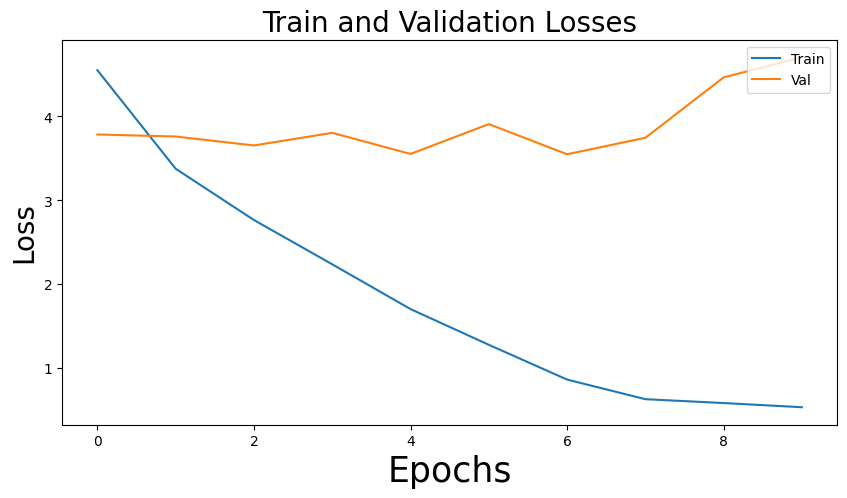

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

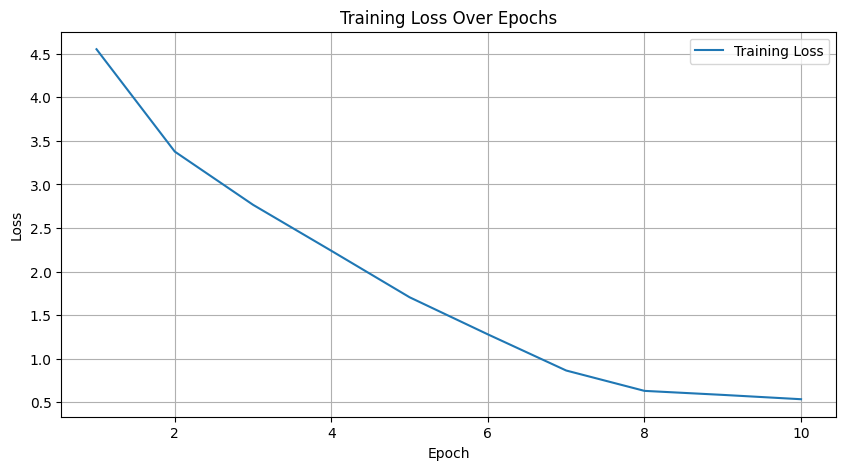

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

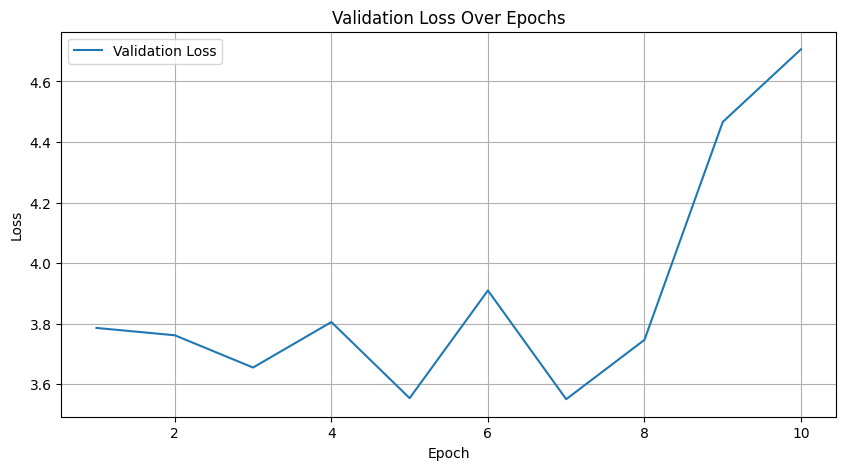

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()

In [ ]:
# Save model to Google Drive
torch.save(model, '/content/drive/MyDrive/Data 255 HW/Assignment 10/bert_finetunedmodel')

In [ ]:
bert_model2 = torch.load('/content/drive/MyDrive/Data 255 HW/Assignment 10/bert_finetunedmodel',map_location=torch.device('cpu'))
bert_model2.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
def predict(context,query):
    inputs = tokenizer.encode_plus(query, context, return_tensors='pt')
    outputs = bert_model2(**inputs)
    answer_start = torch.argmax(outputs[0])  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(outputs[1]) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


In [ ]:
def predict_answer(context,query,answer):
    prediction = predict(context,query)
    print(f"Context: {context}")
    print(f"Question: {query}")
    print(f"Predicted Answer: {prediction}")
    print(f"Real Answer: {answer}")
    print("\n")

## 5. Perform an Inference and show the predicted vs ground truth answers.

In [ ]:
predict_answer(contexts[14],questions[14],answers[14])

Context: Within the Los Angeles Area are the major business districts of Downtown Burbank, Downtown Santa Monica, Downtown Glendale and Downtown Long Beach. Los Angeles itself has many business districts including the Downtown Los Angeles central business district as well as those lining the Wilshire Boulevard Miracle Mile including Century City, Westwood and Warner Center in the San Fernando Valley.
Question: Downtown Burbank is an example of what kind of district?
Predicted Answer: business
Real Answer: business




In [ ]:
predict_answer(contexts[44],questions[44],answers[44])

Context: The Tech Coast is a moniker that has gained use as a descriptor for the region's diversified technology and industrial base as well as its multitude of prestigious and world-renowned research universities and other public and private institutions. Amongst these include 5 University of California campuses (Irvine, Los Angeles, Riverside, Santa Barbara, and San Diego); 12 California State University campuses (Bakersfield, Channel Islands, Dominguez Hills, Fullerton, Los Angeles, Long Beach, Northridge, Pomona, San Bernardino, San Diego, San Marcos, and San Luis Obispo); and private institutions such as the California Institute of Technology, Chapman University, the Claremont Colleges (Claremont McKenna College, Harvey Mudd College, Pitzer College, Pomona College, and Scripps College), Loma Linda University, Loyola Marymount University, Occidental College, Pepperdine University, University of Redlands, University of San Diego, and the University of Southern California.
Question: 

In [ ]:
predict_answer(contexts[66],questions[66],answers[66])

Context: Formed in November 1990 by the equal merger of Sky Television and British Satellite Broadcasting, BSkyB became the UK's largest digital subscription television company. Following BSkyB's 2014 acquisition of Sky Italia and a majority 90.04% interest in Sky Deutschland in November 2014, its holding company British Sky Broadcasting Group plc changed its name to Sky plc. The United Kingdom operations also changed the company name from British Sky Broadcasting Limited to Sky UK Limited, still trading as Sky.
Question: Who is the UK's largest digital subscription television company?
Predicted Answer: sky plc.
Real Answer: BSkyB


